# 1. Albedo optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Enoki library. Those are explained in the [Enoki documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Enoki records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse

# TODO would be great no to have to do this!
ek.set_flag(ek.JitFlag.LoopRecord,  False)

scene = load_file('../scenes/cbox.xml', res=128, max_depth=3)
params = traverse(scene)

2021-06-22 10:40:01 INFO main [xml.cpp:1239] Loading XML file "../scenes/cbox.xml" ..

2021-06-22 10:40:01 INFO main [xml.cpp:1240] Using variant "cuda_ad_rgb"

2021-06-22 10:40:01 INFO main [Scene] Building scene in OptiX ..

2021-06-22 10:40:01 INFO main [Scene] OptiX ready. (took 27ms)

As we enabled a differentiable variant, when printing `params` you will notice the asterisk (`*`) on the left of some parameters which indicates that they are differentiable.

``` python
print(params)

# Output
SceneParameters[
    ...
    redwall.to_world,
  * redwall.bsdf.reflectance.value,
    redwall.vertex_count,
    redwall.face_count,
    redwall.faces,
  * redwall.vertex_positions,
  * redwall.vertex_normals,
  * redwall.vertex_texcoords,
    ...
]
```

### Step 2 - reference image

Our first experiment is going to be very simple: we will change the color of the red wall and then try to recover the original color using differentiation along with the reference image generated above. 

Before starting the optimization process, let's generate a reference image that will be used by the objective function. In contrast to the previous tutorial using `mitsuba.python.util.render` to render images, the differentiable rendering pipeline  involves another rendering function `mitsuba.python.autodiff.render` that is more optimized for this use case as it directly returns a JIT array containing the generated image. As we will soon discover, this function also takes arguments related to differential rendering.

The `mitsuba.python.autodiff` submodule also provides a helper function to reshapes the output into an image of the correct size and exports it to any of the supported image formats (OpenEXR, PNG, JPG, RGBE, PFM) while automatically performing format conversion and gamma correction in the case of an 8-bit output format. The `write_async` argument can be used to performed this task asynchronously which is really handy when one wants to write images during the optimization process.

In [4]:
from mitsuba.python.autodiff import render, write_bitmap, convert_to_bitmap

scene.sensors()[0].sampler().seed(0)
image_ref = render(scene, spp=8)

crop_size = scene.sensors()[0].film().crop_size()
write_bitmap('out_ref.png', image_ref, crop_size)

It is also possible to convert the data iamge to a `mitsuba.core.Bitmap` object and display it using `matplotlib.

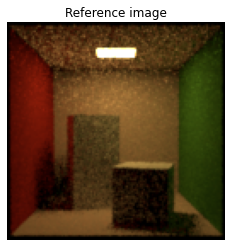

In [5]:
def show_image(img, title):
    plt.imshow(convert_to_bitmap(img, crop_size)); plt.axis('off'); plt.title(title);
    
show_image(image_ref, 'Reference image')

Let’s make a backup copy of this color value for later use and set it's value to a blue-ish color. As always, it is important not to forget to call `params.update()` to inform changed scene objects that they should refresh their internal state. 

This will be our initial state for the optimization process, which we can render and display to attest the difference.

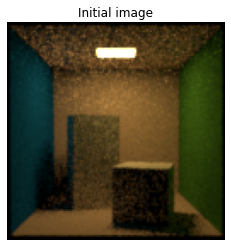

In [6]:
from mitsuba.core import Color3f

key = 'redwall.bsdf.reflectance.value'

params.keep([key])
param_ref = Color3f(params[key])

params[key] = Color3f(0.01, 0.2, 0.9)
params.update()

scene.sensors()[0].sampler().seed(0)
image_init = render(scene, spp=8)
show_image(image_init, 'Initial image')
write_bitmap('out_init.png', image_init, crop_size)

TODO talk about `Optimizer`...

In most cases, we will only be interested in differentiating a small subset of the (typically very large) parameters in the scene graph. It is responsability of the user to specify which parameters should be optimized and this can be done using the `load` method, which support list of keys and regular expressions as input argument to specify more than one parameter at a time.

In [7]:
from mitsuba.python.autodiff import Adam

opt = Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [8]:
errors = []
for it in range(45):    
    scene.sensors()[0].sampler().seed(0)
    # Perform a differentiable rendering of the scene
    image = render(scene, spp=1, unbiased=True, optimizer=opt)

#     write_bitmap('out_%03i.png' % it, image, crop_size)
    
    # Objective: MSE between 'image' and 'image_ref'
    ob_val = ek.hsum_async(ek.sqr(image - image_ref)) / len(image)

    # Back-propagate errors to input parameters
    ek.backward(ob_val)

    # Optimizer: take a gradient step
    opt.step()
    
    opt[key] = ek.clamp(opt[key], 0.0, 1.0)
    
    # Optimizer: Update the scene parameters
    opt.update()
        
    err_ref = ek.hsum(ek.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)

Iteration 000: error=0.920985
Iteration 001: error=0.819501
Iteration 002: error=0.738991
Iteration 003: error=0.671052
Iteration 004: error=0.611847
Iteration 005: error=0.557513
Iteration 006: error=0.507835
Iteration 007: error=0.461291
Iteration 008: error=0.418169
Iteration 009: error=0.377439
Iteration 010: error=0.339548
Iteration 011: error=0.30372
Iteration 012: error=0.270454
Iteration 013: error=0.239131
Iteration 014: error=0.210259
Iteration 015: error=0.183329
Iteration 016: error=0.158839
Iteration 017: error=0.136365
Iteration 018: error=0.116389
Iteration 019: error=0.0985492
Iteration 020: error=0.0832935
Iteration 021: error=0.0692661
Iteration 022: error=0.0563116
Iteration 023: error=0.0447324
Iteration 024: error=0.0342398
Iteration 025: error=0.0252696
Iteration 026: error=0.0174135
Iteration 027: error=0.0112253
Iteration 028: error=0.00618144
Iteration 029: error=0.00293696
Iteration 030: error=0.0008374
Iteration 031: error=0.000545724
Iteration 032: error=0.0

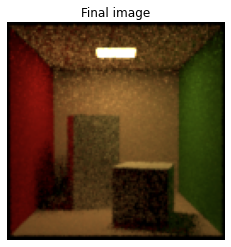

In [9]:
scene.sensors()[0].sampler().seed(0)
image_final = render(scene, spp=8)
show_image(image_final, 'Final image')
write_bitmap('out_final.png', image_final, crop_size)

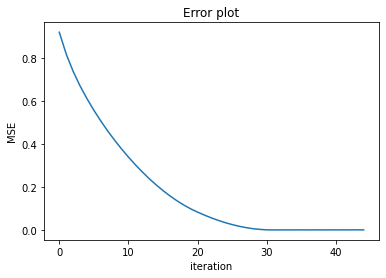

In [10]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Error plot');

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)